In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
from src.models.frontier import MultiStockEnv, Agent, backtest, maybe_make_dir
from src.config import market_tickers
from src.config.model_config import model_parameters

CPU times: user 2.58 s, sys: 1.51 s, total: 4.08 s
Wall time: 2.13 s


In [2]:
# papermill parameters
SEED_LIST = [0] # only works for one value as it is now

#TICKERS = market_tickers.NIK_25_TICKER
TICKERS = ['AAPL', 'AMD', 'CSCO', 'F', 'INTC']
MARKET_NAME = 'TEST_5'
MODEL_BASE_NAME = 'RL_CNN' # use either | 'RL_CNN' | 'RL_str_fcast' | 'RL_all_inp' |
FROM = '2019-01-01' # start of backtest
UNTIL = '2020-01-01' # end of backtest
NB_EPISODES = 200 # backtest model that was trained for this number of episodes

In [3]:
# other constants and parameters
TICKERS.sort()
FILE_PERIOD = '1d' # weekly='5d', daily='1d'
HALF_SPREAD = 0.0005/2.0 # 'a' in transaction cost function
NONLIN_COEFF = 1.0 # 'b' transaction cost function
POWER = 1.5 # power for change in poertfolio vector used in transaction cost
INIT_PORTFOLIO = 100000000.0 # initial portfolio value

USE_FORECASTS = model_parameters[MODEL_BASE_NAME]['use_forecasts'] # whether to use forecasts as inputs to agent policy net or not
NB_FORECASTS = model_parameters[MODEL_BASE_NAME]['nb_forecasts'] # number of forecasts to use in state. Set to None for no forecasts
FORECAST_TYPE = model_parameters[MODEL_BASE_NAME]['forecast_type'] # use 'strong' or 'weak' forecasts (if no forecasts given, this does not matter)
USE_CNN_STATE = model_parameters[MODEL_BASE_NAME]['use_cnn_state'] # whether to pass log-rets block for CNN part of policy net (set to false for forecast only)

TEST_NAME = f'{MARKET_NAME}_{MODEL_BASE_NAME}_seeds_{SEED_LIST[0]}_etc'
RESULTS_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/backtests/'
DATA_DIR = f'../data/{MARKET_NAME}/preprocessed_data/'

In [4]:
#frontier_df = pd.read_csv(f'{RESULTS_DIR}{MARKET_NAME}_{MODEL_BASE_NAME}_seed_frontiers.csv')
frontier_df = pd.read_csv(f'{RESULTS_DIR}{MARKET_NAME}_{MODEL_BASE_NAME}_seeds_{SEED_LIST[0]}_etc.csv')
frontier_df = frontier_df[frontier_df['seed']==SEED_LIST[0]]
frontier_df.head()

,gamma_trade,gamma_risk,seed,excess_return,excess_risk,sharpe
0,0.1,0.1,0,48.078594,27.418340,1.753520
1,0.1,1.0,0,38.360498,23.312767,1.645472
2,0.1,18.0,0,5.333175,4.498644,1.185507
3,0.1,56.0,0,1.146069,2.779251,0.412366
4,0.1,100.0,0,0.469219,2.530161,0.185450


In [5]:
def make_int(x):
    if x.is_integer():
        x = int(x)
    return x

In [6]:
gamma_trade_list = [make_int(i) for i in list(frontier_df['gamma_trade'].round(3))]
gamma_risk_list = [make_int(j) for j in list(frontier_df['gamma_risk'].round(3))]

GAMMA_PAIRS = list(zip(gamma_trade_list, gamma_risk_list))
#GAMMA_PAIRS

######### remove later ##########
# this is just to test a small set
#GAMMA_PAIRS = GAMMA_PAIRS[3:5]
GAMMA_PAIRS
#################################

[(0.1, 0.1),
 (0.1, 1),
 (0.1, 18),
 (0.1, 56),
 (0.1, 100),
 (0.1, 562),
 (0.1, 1000),
 (1, 0.1),
 (1, 1),
 (1, 18),
 (1, 56),
 (1, 100),
 (1, 562),
 (1, 1000),
 (10, 0.1),
 (10, 1),
 (10, 18),
 (10, 56),
 (10, 100),
 (10, 562),
 (10, 1000),
 (60, 0.1),
 (60, 1),
 (60, 18),
 (60, 56),
 (60, 100),
 (60, 562),
 (60, 1000),
 (100, 0.1),
 (100, 1),
 (100, 18),
 (100, 56),
 (100, 100),
 (100, 562),
 (100, 1000)]

In [7]:
print('number of pairs: ', len(GAMMA_PAIRS))
#GAMMA_PAIRS

number of pairs:  35


## create agent(s) and backtest in new backtest env

In [8]:
%%time
# make directory for results if it does not exist already
maybe_make_dir(RESULTS_DIR)

print('creating environment and agent...')
env = MultiStockEnv(tickers=TICKERS, 
                    from_date=FROM,
                    until=UNTIL, 
                    #nb_episodes=100,
                    cash_key='USDOLLAR', 
                    #gamma_risk=GAMMA_RISK, 
                    #gamma_trade=GAMMA_TRADE,
                    #half_spread=HALF_SPREAD, 
                    nonlin_coef=NONLIN_COEFF, 
                    power=POWER, 
                    datadir=DATA_DIR, 
                    state_lookback_window=20, 
                    #distribution=EPISODE_DRAW_DISTRIBUTION,
                    #days_duration=DAYS_IN_EPISODE, 
                    mode='backtest', 
                    random_seed=7,
                    init_portfolio=INIT_PORTFOLIO, 
                    period_in_file_name=FILE_PERIOD, 
                    nb_forecasts=NB_FORECASTS, 
                    forecast_type=FORECAST_TYPE,
                    use_CNN_state=USE_CNN_STATE,
                    verbose=False)

agent = Agent(alpha=0.001, 
              gamma=0.99, 
              n_assets=len(TICKERS)+1, 
              tau=5, 
              lookback_window=20, 
              n_feature_maps=len(TICKERS)+1,
              use_forecasts=USE_FORECASTS,
              use_CNN_state=USE_CNN_STATE)

results_dict = {}
#actions_dict = {}
print('backtesting:')

total_backtests = len(SEED_LIST) * len(GAMMA_PAIRS)
backtest_counter = 0

for RANDOM_SEED in SEED_LIST:
    for (GAMMA_TRADE, GAMMA_RISK) in GAMMA_PAIRS:
        
        backtest_counter += 1
        print(f'\t[{backtest_counter}/{total_backtests}]\t{MODEL_BASE_NAME}: gamma_trade={GAMMA_TRADE}, gamma_risk={GAMMA_RISK}, seed={RANDOM_SEED}...')
        
        # load trained RL model for backtesting
        SAVED_MODEL_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}/models/{MODEL_BASE_NAME}_seed_{RANDOM_SEED}_{NB_EPISODES}'
        # set dir where actions csv file will be saved
        actions_dir = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}'
        
        try:
            rl_rets, rl_actions = backtest(agent, env, weights_file_dir=SAVED_MODEL_DIR, verbose=False)
            
            #rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[1:].index)
            #rl_actions = pd.DataFrame(data=rl_actions, index=env.returns.loc[FROM:UNTIL].iloc[0:].index, columns=TICKERS+['USDOLLAR'])
            rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[:-1].index)
            rl_rets = rl_rets.shift(1)
            rl_rets.iloc[0] = 0
            rl_actions = pd.DataFrame(data=rl_actions[:-1], index=env.returns.loc[FROM:UNTIL].iloc[:-1].index, columns=TICKERS+['USDOLLAR'])
            
            #print(f'rets: {rl_rets.shape}')
            #print(f'actions: {rl_actions.shape}')            
            
            # save actions
            rl_actions.to_csv(f'{actions_dir}/actions.csv')
            #print('actions saved.')

            cash_rets = env.returns.loc[FROM:UNTIL, env.cash_key].iloc[:-1]
            excess_rets = rl_rets - cash_rets

            R_e = excess_rets.mean() * 100 * 252
            sigma_e = excess_rets.std() * 100 * np.sqrt(252)
            sharpe = R_e / sigma_e

            results_dict[(GAMMA_TRADE, GAMMA_RISK, RANDOM_SEED)] = {'excess_return':R_e, 'excess_risk':sigma_e, 'sharpe':sharpe}
        except Exception as e:
            print(f'**error for model: trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}')
            print(e)

creating environment and agent...
backtesting:
	[1/35]	RL_CNN: gamma_trade=0.1, gamma_risk=0.1, seed=0...
	[2/35]	RL_CNN: gamma_trade=0.1, gamma_risk=1, seed=0...
	[3/35]	RL_CNN: gamma_trade=0.1, gamma_risk=18, seed=0...
	[4/35]	RL_CNN: gamma_trade=0.1, gamma_risk=56, seed=0...
	[5/35]	RL_CNN: gamma_trade=0.1, gamma_risk=100, seed=0...
	[6/35]	RL_CNN: gamma_trade=0.1, gamma_risk=562, seed=0...
	[7/35]	RL_CNN: gamma_trade=0.1, gamma_risk=1000, seed=0...
	[8/35]	RL_CNN: gamma_trade=1, gamma_risk=0.1, seed=0...
	[9/35]	RL_CNN: gamma_trade=1, gamma_risk=1, seed=0...
	[10/35]	RL_CNN: gamma_trade=1, gamma_risk=18, seed=0...
	[11/35]	RL_CNN: gamma_trade=1, gamma_risk=56, seed=0...
	[12/35]	RL_CNN: gamma_trade=1, gamma_risk=100, seed=0...
	[13/35]	RL_CNN: gamma_trade=1, gamma_risk=562, seed=0...
	[14/35]	RL_CNN: gamma_trade=1, gamma_risk=1000, seed=0...
	[15/35]	RL_CNN: gamma_trade=10, gamma_risk=0.1, seed=0...
	[16/35]	RL_CNN: gamma_trade=10, gamma_risk=1, seed=0...
	[17/35]	RL_CNN: gamma_tra

In [9]:
results_df = pd.DataFrame(results_dict).T.reset_index()
results_df.columns = ['gamma_trade', 'gamma_risk', 'seed', 'excess_return', 'excess_risk', 'sharpe']
#results_df.to_csv(RESULTS_DIR+TEST_NAME+'.csv', index=False)
#print('saved.')
results_df

,gamma_trade,gamma_risk,seed,excess_return,excess_risk,sharpe
0,0.1,0.1,0,48.078594,27.418340,1.753520
1,0.1,1.0,0,38.360498,23.312767,1.645472
2,0.1,18.0,0,5.333175,4.498644,1.185507
3,0.1,56.0,0,1.146069,2.779251,0.412366
4,0.1,100.0,0,0.469219,2.530161,0.185450
5,0.1,562.0,0,-0.198161,2.317561,-0.085504
6,0.1,1000.0,0,-0.236757,2.305455,-0.102694
7,1.0,0.1,0,48.381455,26.891793,1.799116
8,1.0,1.0,0,39.703497,23.421173,1.695197
9,1.0,18.0,0,5.359387,4.613188,1.161754


In [10]:
rl_rets

Date
2019-01-02    0.000000
2019-01-03   -0.019328
2019-01-04   -0.000798
2019-01-07    0.001097
2019-01-08    0.000308
                ...   
2019-12-23   -0.000049
2019-12-24    0.000661
2019-12-26   -0.000085
2019-12-27    0.000268
2019-12-30   -0.000102
Length: 251, dtype: float32

In [11]:
cash_rets

Date
2019-01-02    0.000095
2019-01-03    0.000094
2019-01-04    0.000095
2019-01-07    0.000096
2019-01-08    0.000096
                ...   
2019-12-23    0.000062
2019-12-24    0.000062
2019-12-26    0.000062
2019-12-27    0.000062
2019-12-30    0.000062
Name: USDOLLAR, Length: 251, dtype: float64

Text(0, 0.5, 'Asset weight')

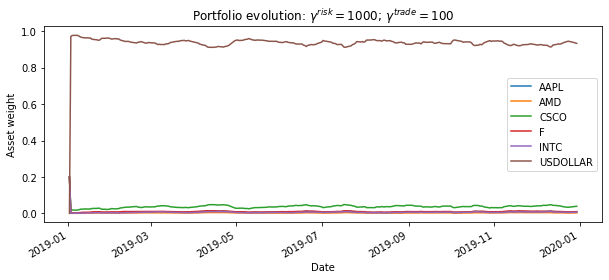

In [28]:
# example of actions plot
rl_actions.plot(figsize=(10,4), title=r'Portfolio evolution: $\gamma^{risk}=$'+f'{GAMMA_RISK}'+r'; $\gamma^{trade}=$'+f'{GAMMA_TRADE}')
plt.ylabel('Asset weight')

In [12]:
print(f'done backtesting for {MODEL_BASE_NAME}.')

done backtesting for RL_CNN.
